<a href="https://colab.research.google.com/github/MLcmore2023/MLcmore2023/blob/main/q_learning_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

notation: using `!` before line makes line into terminal command

In [59]:
! pwd

/content


notation: using `%%capture` in cell prevents any outputs from the cell

In [60]:
!pip install numpy

In [61]:
%%capture
!pip install numpy

# Q learning
Q-learning is a reinforcement learning algorithm that enables an agent to learn optimal actions in a Markov Decision Process (MDP) through trial and error. By using a table called a Q-table, the algorithm iteratively updates the expected future rewards for each state-action pair based on the observed rewards and transitions. The agent selects actions based on the highest Q-value for a given state, gradually improving its decision-making over time. Q-learning combines exploration and exploitation strategies to efficiently navigate the MDP and converge towards an optimal policy, allowing the agent to make informed decisions in uncertain environments.

<img src="https://huggingface.co/datasets/huggingface-deep-rl-course/course-images/resolve/main/en/unit1/RL_process_game.jpg">


# Install libraries
We will first install the relevant libraries for the training environment and result visualization

In [62]:
%%capture

# OpenAI Gym provides a wide variety of pre-built environments for testing reinforcement learning
!pip install gym==0.24

#library for handling graphics
# !pip install pyglet==1.5.1
# !apt install python-opengl
!apt install ffmpeg

# xvfb is a display server that can run on machines with no display hardware and no physical input devices
!apt install xvfb
!pip3 install pyvirtualdisplay

### Setup a Virtual Display
(To generate a replay video of agent and environment)

In [63]:
from pyvirtualdisplay import Display

# make a virtual display (that is invisible) with size 1400x900 pixels
virtual_display = Display(visible=0, size=(1400, 900))
# initialized virtual display
virtual_display.start()

### Import libraries and initialize random generator

In [64]:
import numpy as np
import gym
import random
# Set the seed value to make the random number reproducible
np.random.seed(0)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Environment: Frozen Lake
Frozen lake involves crossing a frozen lake from Start(S) to Goal(G) without falling into any Holes(H) by walking over the Frozen(F) lake.

<img src="https://aleksandarhaber.com/wp-content/uploads/2022/11/Clipboard02.jpg">
<img src="https://149695847.v2.pressablecdn.com/wp-content/uploads/2018/03/Frozen-Lake.png">
The game starts with the player at location [0,0] of the frozen lake grid world with the goal located at far extent of the world e.g. [3,3] for the 4x4 environment.
Holes in the ice are distributed in set locations when using a pre-determined map or in random locations when a random map is generated.
The player makes moves until they reach the goal or fall in a hole.



In [65]:
# Create the FrozenLake-v1 environment using 4x4 map and non-slippery version
env = gym.make("FrozenLake-v1",map_name="4x4",is_slippery=False)

### State space
Observations/States are the information our agent gets from the environment. In the case of a video game, it can be a frame (a screenshot). The observation space is the set of all possible observations that the agent can receive from the environment.

There are two main types of state observations in reinforcement learning. Fully observed environment is when we have a complete description of the state of the world (such as tic tack toe, where there is no hidden information). Partially observed environment is when we only have a partial description of the state (such as Super Mario game, where we can only see the a small frame of the world)

<img src="https://play-lh.googleusercontent.com/Te-zxilwV993RPYKKv8dABN2d5NXzfUBLM6hdBTJGyeJFJsLaxp2k_IDVwQ6mie1Xg" width=25%>
<img src="https://huggingface.co/datasets/huggingface-deep-rl-course/course-images/resolve/main/en/unit1/mario.jpg">

The state space or observation space of Frozen Lake is shown below.

<img src="https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FbUUCWv%2FbtrMozHOvoP%2FJblGBXYQ5rfEQFvMYUZCSk%2Fimg.png">

In Frozen Lake, the observation is an integer value representing the agent’s current position. The number of possible observations is dependent on the size of the map. For example, the 4x4 map has 16 possible observations.

`Observation = current_row * 4 + current_col`

In [66]:
print("Observation Space:\t", env.observation_space)
state_space = env.observation_space.n
print(state_space)

# Get a random observation
print("Sample observation:\t", env.observation_space.sample())

Observation Space:	 Discrete(16)
16
Sample observation:	 11


### Action Space
The Action space is the set of all possible actions in an environment. There are also two types of action spaces in reinforcement learning: discrete or continuous space. An example of continuous space is in a self driving car agent where there is an infinite number of possible actions, since it can turn left 21°, 21.1°, 21.2° or any amount.

In Frozen Lake, the action space is distrete and have only 4 options. Our agent takes a 1-element vector for actions. The action space is the 4 possible input directions:
- 0: LEFT
- 1: DOWN
- 2: RIGHT
- 3: UP



In [67]:
action_space = env.action_space.n
print("Action Space Shape", action_space )
# Take a random action
print("Action Space Sample", env.action_space.sample())

Action Space Shape 4
Action Space Sample 1


## Q-learning algorithm
Q-Learning is an off-policy value-based method that uses a Temporal Difference approach to train its action-value function. The `Q` means the "Quality" (the value) of that action at that state.

- Off-policy: using a different policy for acting (inference) and updating (training).
- Value-based method: finds the optimal policy indirectly by training a value or action-value function that will tell us the value of each state or each state-action pair.
- Temporal Difference approach: updates its action-value function at each step instead of at the end of the episode.

<img src="https://huggingface.co/datasets/huggingface-deep-rl-course/course-images/resolve/main/en/unit3/Q-function-2.jpg">

The goal of a reinforcement learning agent is to have an optimal policy $π$*.


Q-Learning steps:
- Trains a Q-function (an action-value function), which internally is a Q-table that contains all the state-action pair values.
- Given a state and action, our Q-function will search its Q-table for the corresponding value.
- When the training is done, we have an optimal Q-function, which means we have optimal Q-table.
- And if we have an optimal Q-function, we have an optimal policy since we know the best action to take at each state.

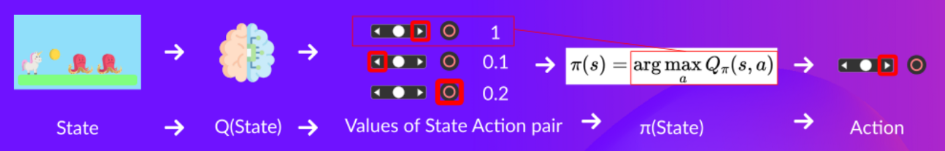


## Create and Initialize the Q-table

This table contains the corresponding state-action values for each state and action.

For example, in a 2x3 world (which contains 6 states), the Q table is a 6x4 matrix, which have a value for all state-action pairs representing the quality of this action.

<img src="https://huggingface.co/datasets/huggingface-deep-rl-course/course-images/resolve/main/en/unit3/Maze-3.jpg" width=50%>

Since we initially knows nothing about environment, we will assign zeros to this table.



In [68]:
def initialize_q_table(state_space, action_space):
  Qtable = np.zeros( (state_space, action_space) )
  return Qtable

In [69]:
Qtable_frozenlake = initialize_q_table(state_space, action_space)
print(Qtable_frozenlake)

[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]


### The Exploration/Exploitation trade-off
There are two competing strategies when learning in an uncertain environment.
- Exploration: exploring the environment by trying random actions in order to find more information about the environment. By exploring, the agent can discover potentially better actions or states that lead to higher rewards. However, exploration comes with uncertainty and might lead to suboptimal decisions initially.
- Exploitation: exploiting known information to maximize the reward. Exploiting what is already known can lead to short-term gains and better performance in familiar situations. However, it comes with the risk of overlooking potentially better actions that have not been thoroughly explored.

Balancing exploration and exploitation is crucial to ensure efficient learning and optimal decision-making. If the agent exploits too much, it may miss out on discovering better actions, leading to a suboptimal policy. On the other hand, too much exploration can lead to slow convergence and ineffective decision-making in the long run. One strategry for finding the right balance is the epsilon-greedy policy.





### Epsilon-greedy policy
Epsilon-greedy is an exploration-exploitation balancing strategy. It selects the best-known action with a high probability (1 - ε) and choosing a random action with a small probability (ε). During training, epsilon decreases over time. Therefore, the agent initially explores more due to the non-zero probability of selecting random actions. As training progresses and the agent's Q-values improve, the agent will do more exploitation (choosing the best-known action)

In [70]:
def epsilon_greedy_policy(Qtable, state, epsilon):
  # Randomly generate a number between 0 and 1
  random_int = random.random()
  # if random_int > greater than epsilon --> exploitation
  if random_int < epsilon: # the probability of this being true is epsilon
    # to do exploration, we choose a random action
    action = env.action_space.sample()
  else:
    # to do exploitation, we take the action with the highest value given a state
    action = np.argmax(Qtable[state])
  return action

### Greedy policy
Given the value function, it will take actions that always lead to the biggest reward

In [71]:
def greedy_policy(Qtable, state):
  # Exploitation: take the action with the highest state, action value
  action = np.argmax(Qtable[state])

  return action

### Define the hyperparameters

In [72]:
# Training parameters
n_training_episodes = 10000  # Total training episodes
learning_rate = 0.7          # Learning rate

# Evaluation parameters
n_eval_episodes = 100        # Total number of test episodes

# Environment parameters
max_steps = 99               # Max steps per episode
gamma = 0.95                 # Discounting rate of how much we value future rewards

# Exploration parameters
max_epsilon = 1.0             # Exploration probability at start
min_epsilon = 0.05            # Minimum exploration probability
decay_rate = 0.0005            # Exponential decay rate for exploration prob (how faster we change from exploration to exploitation)

## Training the model

We will use the Bellman equation to update the Q table, which will make our agents better over training. The Bellman equation for Q-learning is given by:

$ Q(s, a) = Q(s, a) + \alpha \left( r + \gamma \cdot \max_{a'} Q(s', a') - Q(s, a) \right) $

Where:
- $ Q(s, a) $ is the Q-value for state $ s $ and action $ a $.
- $ \alpha $ is the learning rate, controlling how much the new information overrides the old Q-value (0 < $ \alpha $ < 1).
- $ r $ is the immediate reward received after taking action $ a $ in state $ s $.
- $ \gamma $ is the discount factor, determining the importance of future rewards (0 < $ \gamma $ < 1).
- $ \max_{a'} Q(s', a') $ represents the maximum Q-value for the next state $ s' $ and all possible actions $ a' $.

Rewards in the future, even if it is bigger (more cheese), will be more discounted since we’re not really sure we’ll be able to get it. This means our agent cares more about the short term reward, since our agent might die before ever getting the reward


In [73]:
def train(n_training_episodes, min_epsilon, max_epsilon, decay_rate, env, max_steps, Qtable):
  for episode in range(n_training_episodes):
    # Reduce epsilon as training goes on, because we need less and less exploration to prioritize exploitation over exploration
    epsilon = min_epsilon + (max_epsilon - min_epsilon)*np.exp(-decay_rate*episode)

    # Reset the environment
    state = env.reset()
    step = 0
    done = False

    # take as many steps as needed to finish a game
    for step in range(max_steps):
      # Choose the action At using epsilon greedy policy
      action = epsilon_greedy_policy(Qtable, state, epsilon)

      # Take action At and observe Rt+1 and St+1
      # Take the action (a) and observe the outcome state(s') and reward (r)
      new_state, reward, done, info = env.step(action)

      # Update Q(s,a):= Q(s,a) + lr [R(s,a) + gamma * max Q(s',a') - Q(s,a)]
      Qtable[state][action] = Qtable[state][action] + learning_rate * (reward + gamma * np.max(Qtable[new_state]) - Qtable[state][action])

      # If done, finish the episode
      if done:  # if game is won or if player died (falled into hole)
        break

      # Our state is the new state
      state = new_state
  return Qtable

In [74]:
Qtable_frozenlake = train(n_training_episodes, min_epsilon, max_epsilon, decay_rate, env, max_steps, Qtable_frozenlake)

## Trained Q-Learning table

In [75]:
Qtable_frozenlake

array([[0.73509189, 0.77378094, 0.77378094, 0.73509189],
       [0.73509189, 0.        , 0.81450625, 0.77378094],
       [0.77378094, 0.857375  , 0.77378094, 0.81450625],
       [0.81450625, 0.        , 0.77378094, 0.77378094],
       [0.77378094, 0.81450625, 0.        , 0.73509189],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.9025    , 0.        , 0.81450625],
       [0.        , 0.        , 0.        , 0.        ],
       [0.81450625, 0.        , 0.857375  , 0.77378094],
       [0.81450625, 0.9025    , 0.9025    , 0.        ],
       [0.857375  , 0.95      , 0.        , 0.857375  ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.9025    , 0.95      , 0.857375  ],
       [0.9025    , 0.95      , 1.        , 0.9025    ],
       [0.        , 0.        , 0.        , 0.        ]])

## Model evaluation
Evaluate the agent for ``n_eval_episodes`` episodes and returns average reward and std of reward.


In [83]:
episode_rewards = []
# repeat for n_eval_episodes times
for episode in range(n_eval_episodes):
  state = env.reset()
  step = 0
  done = False
  total_rewards_ep = 0

  # take as many steps as needed to finish a game
  for step in range(max_steps):
    # Take the action (index) that have the maximum expected future reward given that state
    action = np.argmax(Qtable_frozenlake[state][:])
    new_state, reward, done, info = env.step(action)
    total_rewards_ep += reward

    if done: # if game is won or if player died
      break
    state = new_state
  episode_rewards.append(total_rewards_ep)



In [85]:
# calculate mean and standard deviation of the rewards
mean_reward = np.mean(episode_rewards)
std_reward = np.std(episode_rewards)

print("Mean_reward =",mean_reward, "+-",std_reward)

Mean_reward = 1.0 +/- 0.0


## Visualizing the results
We will use imageio and ffmpeg to record a playback video of the agent player Frozen Lake

In [86]:
!pip install imageio imageio_ffmpeg
import imageio

In [87]:
def record_video(env, Qtable, out_directory, fps=1):
  images = []
  done = False
  state = env.reset(seed=random.randint(0,500))
  img = env.render(mode='rgb_array')
  images.append(img)
  while not done:
    # Take the action (index) that have the maximum expected future reward given that state
    action = np.argmax(Qtable[state][:])
    state, reward, done, info = env.step(action) # We directly put next_state = state for recording logic
    img = env.render(mode='rgb_array')
    images.append(img)
  imageio.mimsave(out_directory, [np.array(img) for i, img in enumerate(images)], fps=fps)

Saving animated file as gif with 1 frame per second

In [80]:
video_path="/content/replay.gif"
video_fps=1
record_video(env, Qtable_frozenlake, video_path, video_fps)

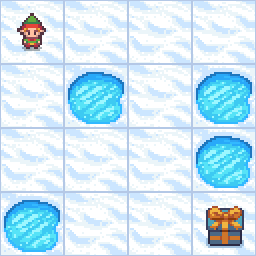

In [88]:
from IPython.display import Image
Image('./replay.gif')

### References
- https://huggingface.co/learn/deep-rl-course/unit0/introduction
- https://www.gymlibrary.dev/environments/toy_text/frozen_lake/
- https://gymnasium.farama.org/environments/toy_text/frozen_lake/
- https://sarah0518.tistory.com/149
- https://analyticsindiamag.com/openai-gym-frozen-lake-beginners-guide-reinforcement-learning/
